In [1]:
import os.path as osp
import dotenv
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

InducingCytokine = candidate_subclass('InducingCytokine', ['cytokine', 'cell_type'])
train_cands = session.query(InducingCytokine).filter(InducingCytokine.split == 0).all()
dev_cands = session.query(InducingCytokine).filter(InducingCytokine.split == 1).all()

In [3]:
len(train_cands), len(dev_cands)

(8011, 168)

In [4]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

In [41]:
??rule_regex_search_tagged_text

In [25]:
train_cands[0].get_parent()

Sentence(Document PMC5691654,153,b'The controversial requirement of TGF-\xce\xb2 in Th17 differentiation was further highlighted in human studies.')

In [22]:
get_tagged_text(train_cands[0])

'The controversial requirement of {{A}} in {{B}} differentiation was further highlighted in human studies.'

In [62]:
def ltp(x):
    x = [v for v in x if v]
    return '(' + '|'.join(x) + ')'

terms = {
    'r_diff': [
        # noun, verb (present or 3rd person present), verb (past or participle)
        ('differentation', 'differentiate', 'differentiated'), 
        ('formation', 'form', 'formed'), 
        ('generation', 'generate', 'generated'),
        ('polarization', 'polarize', 'polarized'),
        ('development', 'develop', 'developed'),
        ('induction', None, None),
    ],
    'r_push': [
        ('inducer', 'induce', 'induced'),
        ('driver', 'drive', 'drove|driven'),
        ('regulator', 'regulate', 'regulated'),
    ],
    'r_prod': [
        ('producer|production', 'produce', 'produced'),
        ('generator|generation', 'generate', 'generated'),
        ('creator|creation', 'create', 'created'),
    ],
    'r_secr': [
        ('sectretor|secretion', 'secrete', 'secreted'),
        ('expressor|expression', 'express', 'expressed'),
        ('producer|production', 'produce', 'produced'),
        ('releaser|release', 'release', 'released'),
    ]
}
terms_map = {}
for k, v in terms.items():
    terms_map[k+'_n'] = ltp([r[0] for r in v] +['cell ' + r[0] for r in v if r[0]])
    terms_map[k+'_v'] = ltp([r[1] for r in v] +[r[1]+('es' if r[1].endswith('s') else 's') for r in v if r[1]])
    terms_map[k+'_p'] = ltp([r[2] for r in v])
    
terms_map['n_do'] = '(cannot|can\'t|will not|won\'t|does not|doesn\'t)'
terms_map

{'r_diff_n': '(differentation|formation|generation|polarization|development|induction|cell differentation|cell formation|cell generation|cell polarization|cell development|cell induction)',
 'r_diff_v': '(differentiate|form|generate|polarize|develop|differentiates|forms|generates|polarizes|develops)',
 'r_diff_p': '(differentiated|formed|generated|polarized|developed)',
 'r_push_n': '(inducer|driver|regulator|cell inducer|cell driver|cell regulator)',
 'r_push_v': '(induce|drive|regulate|induces|drives|regulates)',
 'r_push_p': '(induced|drove|driven|regulated)',
 'r_prod_n': '(producer|production|generator|generation|creator|creation|cell producer|production|cell generator|generation|cell creator|creation)',
 'r_prod_v': '(produce|generate|create|produces|generates|creates)',
 'r_prod_p': '(produced|generated|created)',
 'r_secr_n': '(sectretor|secretion|expressor|expression|producer|production|releaser|release|cell sectretor|secretion|cell expressor|expression|cell producer|productio

In [132]:

def search_subst_pattern(c, pattern):
    for k, v in terms_map.items():
        pattern = pattern.replace('{{' + k + '}}', v)
    return rule_regex_search_tagged_text(c, pattern, 1)

def LF_ind_pos_1(c):
    # predominance of [cytokine] drives [cell type] differentiation
    # [cytokine] regulates [cell type] differentiation
    return search_subst_pattern(c, r'{{A}} {{r_push_v}} {{B}} {{r_diff_n}}')

def LF_ind_pos_2(c):
    # Furthermore, a key inducer of [cell type] cell differentiation, [cytokine] ...
    return search_subst_pattern(c, r'{{r_push_n}} of {{B}} {{r_diff_n}}[,]? {{A}}')

def LF_ind_pos_3(c):
    # [cytokine] has been shown to induce [cell type] cell differentiation
    # [cytokine] and [cytokine] induce [cell type] cell differentiation
    return search_subst_pattern(c, r'{{A}}.{0,30} {{r_push_v}} {{B}} {{r_diff_n}}')

def LF_ind_pos_4(c):
    # whereas [cytokine], critical for [cell type] and [cell type] cell induction
    # revealed that [cytokine] was an essential cytokine in mediating [cell type] cell development
    return search_subst_pattern(c, r'{{A}}.{0,30} (critical|essential|important) .{0,30}{{B}} {{r_diff_n}}')

def LF_ind_pos_5(c):
    # The role of [cytokine] ... to its ability to polarize T-helper cells toward the [cell type] type
    return search_subst_pattern(c, r'{{A}}.{0,30}ability to {{r_diff_v}}.{0,30}toward.{0,30}{{B}}')

def LF_ind_pos_6(c):
    # [cell type] … driven by [cytokine]
    return search_subst_pattern(c, r'{{B}}.{0,30} {{r_push_p}} (by|via|using|through) {{A}}')

def LF_ind_pos_7(c):
    # [cytokine] regulates [cell type] differentiation
    return search_subst_pattern(c, r'{{A}} (regulate[s]?|control[s]?) {{B}} {{r_diff_n}}')

def LF_ind_pos_8(c):
    # lacking other molecules involved in [cell type] differentiation, such as [cytokine]
    return search_subst_pattern(c, r'{{B}} {{r_diff_n}}[,]?.{0,15}(such as|like|including).{0,15}{{A}}')

def LF_ind_pos_9(c):
    # [cytokine], a component of the [cell type] paradigm
    return search_subst_pattern(c, r'{{A}}[,]?.{0,15}(component|part|constituent)of the {{B}}')

def LF_ind_pos_10(c):
    # confirms that [cytokine] is a critical cytokine in the commitment to [cell type] 
    return search_subst_pattern(c, r'{{A}}.{0,30}(critical|essential).{0,30}commitment to {{B}}')

def LF_ind_pos_11(c):
    # cells exposed to [cytokine] can … develop into [cell type]
    return search_subst_pattern(c, r'{{A}}.{0,30}{{r_diff_v}} into {{B}}')

def LF_ind_pos_12(c):
    # [cell type] cells require [cytokine] for their generation
    return search_subst_pattern(c, r'{{B}} cell[s]? (need[s]?|require[s]?) {{A}}.{0,15}{{r_prod_n}}')

def LF_ind_pos_13(c):
    # TGF-B is important for differentiation of Th17
    return search_subst_pattern(c, r'{{A}}.{0,30}(critical|essential|important).{0,10}{{r_diff_n}}.{0,10}{{B}}')
    
# TODO: keep going @ [cytokine] induce(s) the development of [cell type]

def LF_ind_neg_1(c):
    # [cytokine] cannot produce [cell type] cells de novo from naïve T cells 
    return -1*search_subst_pattern(c, r'{{A}} {{n_do}} {{r_prod_v}} {{B}}')

def LF_ind_neg_2(c):
    # [cell type] cells do not respond to [cytokine]
    return -1*search_subst_pattern(c, r'{{B}} cell[s]? {{n_do}} (respond|react) to {{A}}')

def LF_ind_bth_1(c):
    # Return signed result for whether or not mention of cytokine is at most X chars before cell type mention
    return 1 if re.search(r'{{A}}.{0,100}{{B}}', get_tagged_text(c), flags=re.I) else -1

In [133]:
def LF_sec_pos_1(c):
    # ... regulates [cell type] differentiation, inducing [cytokine] expression
    return search_subst_pattern(c, r'{{B}}.{0,15}{{r_prod_n}}.{0,15}(inducing|causing) {{A}} {{r_secr_n}}')

def LF_sec_pos_2(c):
    # [cell type] cells produce [cytokines]
    # [cell type] cells, which secrete [cytokine]
    return search_subst_pattern(c, r'{{B}}.{0,15}{{r_secr_v}} {{A}}')

def LF_sec_pos_3(c):
    # induced [cell type] cell expansion and [cytokine] release
    return search_subst_pattern(c, r'{{B}}.{0,30}{{A}} {{r_secr_n}}')

def LF_sec_pos_4(c):
    # Considerable amounts of [cytokine] were released by the [cell type] cells
    # significantly higher levels of [cytokine] were secreted by [cell type]
    return search_subst_pattern(c, r'{{A}}.{0,15}{{r_secr_p}}.{0,15}{{B}}')

def LF_sec_pos_5(c):
    # [cell type] cells secreted significantly higher levels of [cytokine]
    return search_subst_pattern(c, r'{{B}}.{0,15}{{r_secr_p}}.{0,15}{{A}}')

def LF_sec_bth_1(c):
    # Return signed result for whether or not mention of cell type is at most X chars before cytokine mention
    return 1 if re.search(r'{{B}}.{0,100}{{A}}', get_tagged_text(c), flags=re.I) else -1

In [134]:
#re.search(r'blah (cell[s]?)?do stuff', 'blah do stuff')

#### Composite Functions

In [135]:
def get_lfs(filter_fn=None):
    if filter_fn is None:
        filter_fn = lambda k: True
    gl = globals()
    return [v for k, v in gl.items() if callable(v) and filter_fn(k)]

funs_ind_neg_sec = get_lfs(lambda k: k.startswith('LF_sec_pos'))
print('LF_ind_neg_sec: Num functions composed = {} (names = {})'.format(
    len(funs_ind_neg_sec), [f.__name__ for f in funs_ind_neg_sec]
))

def LF_ind_neg_sec(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return -1*max([f(c) for f in funs_ind_neg_sec])

LF_ind_neg_sec: Num functions composed = 5 (names = ['LF_sec_pos_1', 'LF_sec_pos_2', 'LF_sec_pos_3', 'LF_sec_pos_4', 'LF_sec_pos_5'])


In [136]:
LFs = get_lfs(lambda k: k.startswith('LF_ind'))
print('Labeling functions found:\n{}'.format('\n'.join(sorted([f.__name__ for f in LFs]))))

Labeling functions found:
LF_ind_bth_1
LF_ind_neg_1
LF_ind_neg_2
LF_ind_neg_sec
LF_ind_pos_1
LF_ind_pos_10
LF_ind_pos_11
LF_ind_pos_12
LF_ind_pos_13
LF_ind_pos_2
LF_ind_pos_3
LF_ind_pos_4
LF_ind_pos_5
LF_ind_pos_6
LF_ind_pos_7
LF_ind_pos_8
LF_ind_pos_9


In [137]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [99]:
%time L_train = labeler.apply(split=0)
L_train


  0%|          | 16/8011 [00:00<00:51, 155.24it/s]

Clearing existing...
Running UDF...



 39%|███▉      | 3140/8011 [00:15<00:25, 188.69it/s]


 80%|████████  | 6410/8011 [00:31<00:06, 247.20it/s]


100%|██████████| 8011/8011 [00:38<00:00, 208.98it/s]

CPU times: user 38 s, sys: 578 ms, total: 38.5 s
Wall time: 38.5 s


<8011x16 sparse matrix of type '<class 'numpy.int64'>'
	with 8213 stored elements in Compressed Sparse Row format>

In [100]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_ind_pos_1,0,0.000000,0.000000,0.000000
LF_ind_pos_2,1,0.000000,0.000000,0.000000
LF_ind_pos_3,2,0.000125,0.000125,0.000000
LF_ind_pos_4,3,0.000499,0.000499,0.000000
LF_ind_pos_5,4,0.000000,0.000000,0.000000
LF_ind_pos_6,5,0.001248,0.001248,0.001248
LF_ind_pos_7,6,0.000000,0.000000,0.000000
LF_ind_neg_1,7,0.000000,0.000000,0.000000
LF_ind_bth_1,8,1.000000,0.025215,0.007365
LF_ind_neg_sec,9,0.022719,0.022719,0.005867


## Train Generative Model

In [101]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

105

In [102]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [103]:
train_marginals = gen_model.marginals(L_train)

In [104]:
train_marginals.shape

(8011,)

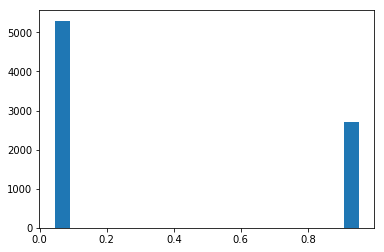

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [106]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.611111,0.0018,0.428571,0.000613
1,0.448276,0.0029,0.388889,0.001430
2,0.470588,0.0017,0.571429,0.000817
3,0.375000,0.0016,0.500000,0.001021
4,0.428571,0.0007,0.000000,0.000000
5,0.722222,0.0018,0.714286,0.001021
6,0.500000,0.0020,0.600000,0.001226
7,0.666667,0.0015,0.750000,0.001226
8,0.955090,0.8684,0.955450,0.823698
9,0.514286,0.0035,0.625000,0.002043


In [107]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 8011 marginals


## Check Against Dev Labels

In [108]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True)
# Labels return as 0 when a candidate has no gold label loaded but in this case,
# unlabeled candidates in the dev set are to be treated as negative instances
L_gold_dev = np.where(L_gold_dev == 1, 1, -1)
assert np.all(np.in1d(L_gold_dev, [-1, 1]))
L_gold_dev[:100]

array([-1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1,
       -1,  1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1,
       -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1])

In [109]:
L_dev = labeler.apply_existing(split=1)


  7%|▋         | 11/168 [00:00<00:01, 106.36it/s]

Clearing existing...
Running UDF...



100%|██████████| 168/168 [00:01<00:00, 160.11it/s]

In [128]:
np.argwhere(L_gold_dev > 0).squeeze()

array([  4,   8,  32,  37,  40,  47,  49,  52,  54,  56,  58,  61,  63,
        65,  69,  73,  81,  82,  93, 106, 107, 113, 122, 132, 136, 141,
       145, 151, 154, 159])

In [143]:
cand = dev_cands[58]

In [144]:
cand

InducingCytokine(Span("b'TGF-\xce\xb2'", sentence=11470, chars=[89,93], words=[15,15]), Span("b'iTreg'", sentence=11470, chars=[118,122], words=[21,21]))

In [145]:
cand.get_parent()

Sentence(Document PMC2646571,34,b'We report that Gfi-1 suppresses both Th17 and CD103+ iTreg cell differentiation, whereas TGF-\xce\xb2, critical for Th17 and iTreg cell induction, down-regulates Gfi-1 expression.')

In [146]:
df_dev = pd.DataFrame(L_dev.toarray()).assign(label=L_gold_dev)
df_dev.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,label
0,0,0,0,0,0,0,0,0,-1,-1,0,0,0,0,0,0,-1
1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,-1
2,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,-1
3,0,0,0,0,0,0,0,0,-1,-1,0,0,0,0,0,0,-1
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [142]:
df_dev[df_dev['label'] > 0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,label
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,1
32,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,1
37,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,1
40,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,1
47,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
49,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
52,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
54,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
56,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [111]:
_ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.733
Neg. class accuracy: 0.797
Precision            0.44
Recall               0.733
F1                   0.55
----------------------------------------
TP: 22 | FP: 28 | TN: 110 | FN: 8



In [112]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/snorkel/annotations.py:137: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_ind_pos_1,0,0.005952,0.005952,0.0,1,0,0,0,1.000000,0.444444
LF_ind_pos_2,1,0.000000,0.000000,0.0,0,0,0,0,NaN,0.363636
LF_ind_pos_3,2,0.011905,0.011905,0.0,2,0,0,0,1.000000,0.363636
LF_ind_pos_4,3,0.005952,0.005952,0.0,1,0,0,0,1.000000,0.307692
LF_ind_pos_5,4,0.000000,0.000000,0.0,0,0,0,0,NaN,0.555556
LF_ind_pos_6,5,0.000000,0.000000,0.0,0,0,0,0,NaN,0.392857
LF_ind_pos_7,6,0.000000,0.000000,0.0,0,0,0,0,NaN,0.466667
LF_ind_neg_1,7,0.000000,0.000000,0.0,0,0,0,0,NaN,0.647059
LF_ind_bth_1,8,1.000000,0.089286,0.0,22,28,8,110,0.785714,0.953575
LF_ind_neg_sec,9,0.047619,0.047619,0.0,0,0,0,8,1.000000,0.416667
